In [4]:
! pip install -q kaggle

In [33]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d salader/dogs-vs-cats

 98% 1.05G/1.06G [00:12<00:00, 150MB/s]
100% 1.06G/1.06G [00:12<00:00, 92.3MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,Input

In [9]:
# loading images in batches
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [10]:
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(normalize)
validation_ds = validation_ds.map(normalize)

In [22]:
model = Sequential()

model.add(Input((256,256,3)))

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

In [27]:
history = model.fit(train_ds,epochs=10, initial_epoch=3,validation_data=validation_ds, callbacks=[early_stopping])

Epoch 4/10
625/625 [==============================] - 66s 105ms/step - loss: 0.7182 - accuracy: 0.5084 - val_loss: 0.6956 - val_accuracy: 0.5002
Epoch 5/10
625/625 [==============================] - 64s 102ms/step - loss: 0.6942 - accuracy: 0.4959 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
625/625 [==============================] - 66s 105ms/step - loss: 0.6931 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
625/625 [==============================] - 66s 105ms/step - loss: 0.6931 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 7: early stopping


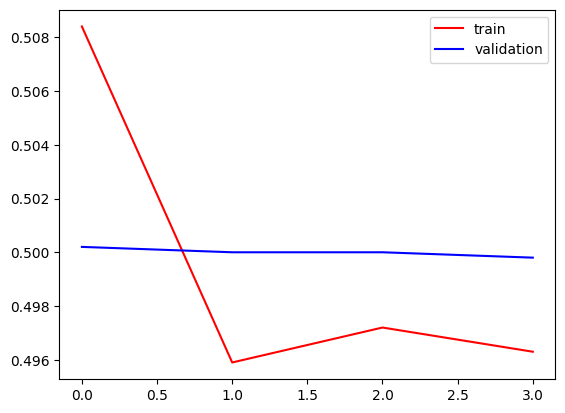

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

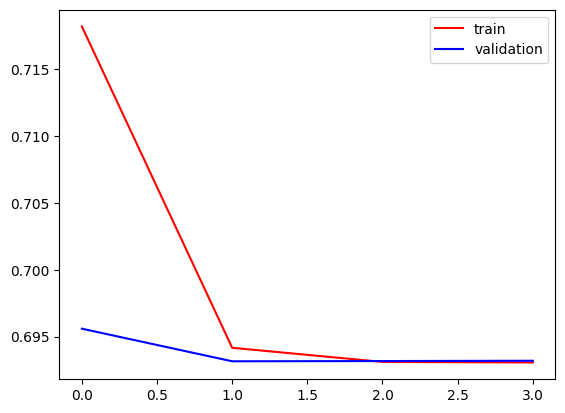

In [29]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [34]:
import cv2

In [38]:
test_img = cv2.imread('/content/cat_test.jpeg')

In [39]:
test_img.shape

(360, 543, 3)

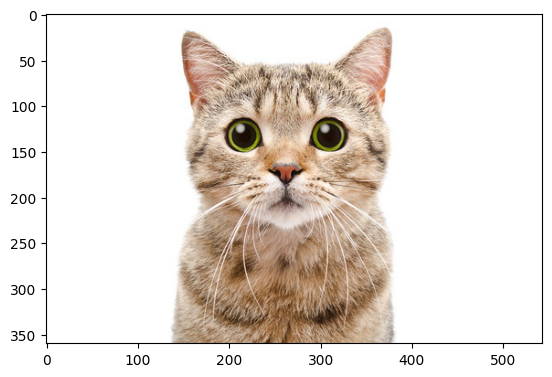

In [41]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [42]:
test_img = cv2.resize(test_img,(256,256))

In [43]:
test_input = test_img.reshape((1,256,256,3))

In [44]:
model.predict(test_input)

1/1 [==============================] - 0s 317ms/step


array([[0.49787462]], dtype=float32)

# Using Data Augmentation

In [45]:
from keras.preprocessing.image import ImageDataGenerator

In [48]:
# generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [52]:
# augmenting data
train_ds = train_datagen.flow_from_directory(
    directory = '/content/train',
    class_mode = 'binary',
    batch_size=32,
    target_size=(256,256)
)

validation_ds = val_datagen.flow_from_directory(
    directory = '/content/test',
    class_mode = 'binary',
    batch_size=32,
    target_size=(256,256)
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [53]:
model = Sequential()

model.add(Input((256,256,3)))

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [54]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [60]:
history = model.fit(
    train_ds,
    steps_per_epoch=256,
    epochs=10,
    validation_data=validation_ds,
)

Epoch 6/10
256/256 [==============================] - 143s 559ms/step - loss: 0.6879 - accuracy: 0.6232 - val_loss: 0.6530 - val_accuracy: 0.6484
Epoch 7/10
256/256 [==============================] - 145s 566ms/step - loss: 0.6180 - accuracy: 0.6632 - val_loss: 0.5550 - val_accuracy: 0.7144
Epoch 8/10
256/256 [==============================] - 148s 578ms/step - loss: 0.5427 - accuracy: 0.7269 - val_loss: 0.5208 - val_accuracy: 0.7342
Epoch 9/10
256/256 [==============================] - 145s 563ms/step - loss: 0.5079 - accuracy: 0.7507 - val_loss: 0.5243 - val_accuracy: 0.7188
Epoch 10/10
256/256 [==============================] - 139s 544ms/step - loss: 0.4830 - accuracy: 0.7676 - val_loss: 0.5255 - val_accuracy: 0.7334
Epoch 10: early stopping


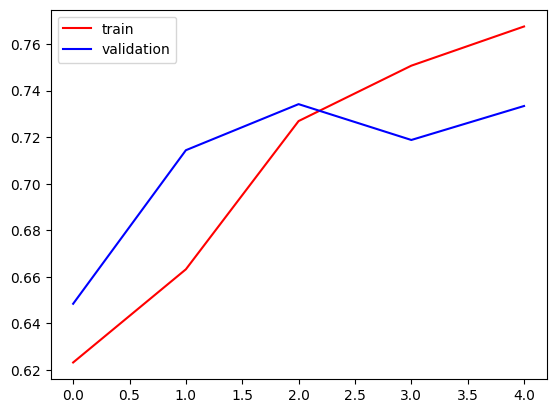

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

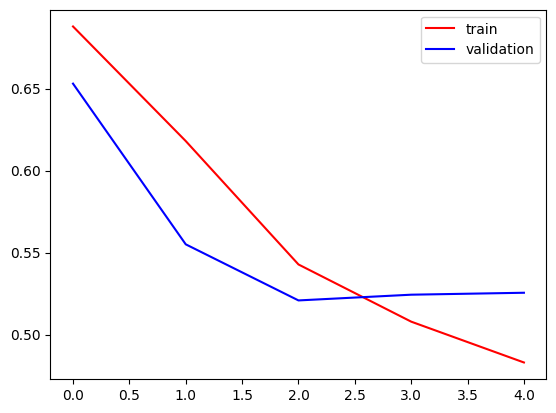

In [62]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [67]:
import cv2

test_img = cv2.imread('/content/cat_test.jpeg')

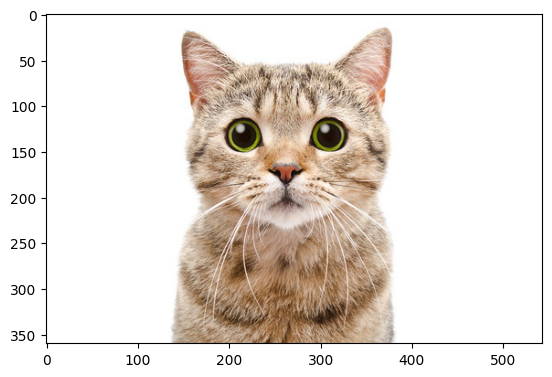

In [68]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [66]:
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))
model.predict(test_input)

1/1 [==============================] - 1s 571ms/step


array([[0.]], dtype=float32)

# Using VGGNET and Data Augmentation

In [97]:
from keras.preprocessing.image import ImageDataGenerator

# generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# augmenting data
train_ds = train_datagen.flow_from_directory(
    directory = '/content/train',
    class_mode = 'binary',
    batch_size=32,
    target_size=(256,256)
)

validation_ds = val_datagen.flow_from_directory(
    directory = '/content/test',
    class_mode = 'binary',
    batch_size=32,
    target_size=(256,256)
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [98]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

conv_base.trainable = False

In [99]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_11 (Dense)            (None, 256)               8388864   
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 23103809 (88.13 MB)
Trainable params: 8389121 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [100]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [94]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.02,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

In [101]:
history = model.fit(
    train_ds,
    steps_per_epoch=256,
    epochs=5,
    validation_data=validation_ds,
    callbacks=[early_stopping]
)

Epoch 1/5
256/256 [==============================] - 178s 690ms/step - loss: 0.4543 - accuracy: 0.8375 - val_loss: 0.2351 - val_accuracy: 0.8984
Epoch 2/5
256/256 [==============================] - 162s 632ms/step - loss: 0.2082 - accuracy: 0.9115 - val_loss: 0.1783 - val_accuracy: 0.9284
Epoch 3/5
256/256 [==============================] - 162s 633ms/step - loss: 0.1845 - accuracy: 0.9226 - val_loss: 0.1542 - val_accuracy: 0.9368
Epoch 4/5
256/256 [==============================] - 161s 629ms/step - loss: 0.1763 - accuracy: 0.9280 - val_loss: 0.1646 - val_accuracy: 0.9310
Epoch 5/5
256/256 [==============================] - 162s 631ms/step - loss: 0.1702 - accuracy: 0.9290 - val_loss: 0.1794 - val_accuracy: 0.9242
Epoch 5: early stopping


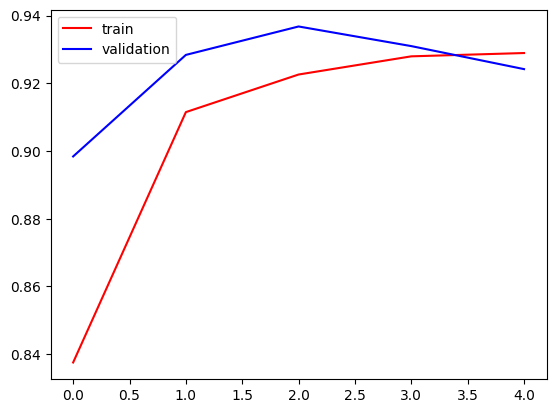

In [102]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

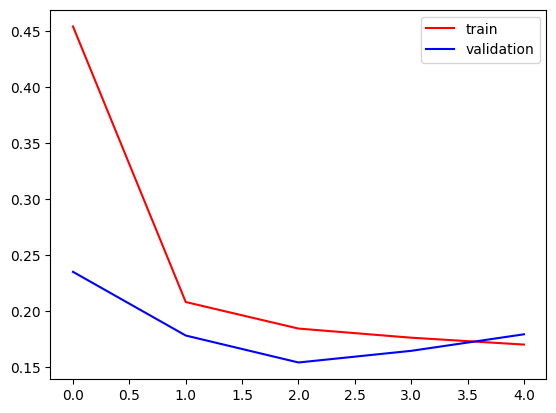

In [103]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

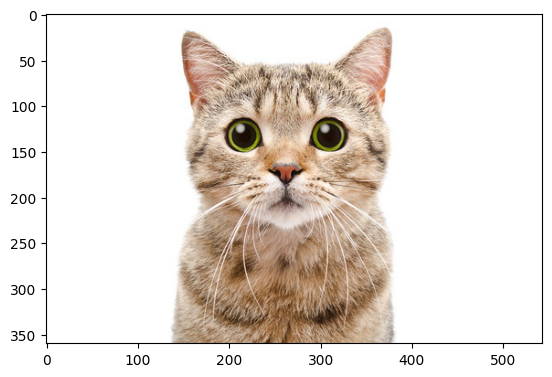

In [104]:
import cv2
test_img = cv2.imread('/content/cat_test.jpeg')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [105]:
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))
model.predict(test_input)

1/1 [==============================] - 0s 213ms/step


array([[0.]], dtype=float32)

## Traning last convolution block of VGGNET

Augmentation wont be needed here

In [84]:
# loading images in batches
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(normalize)
validation_ds = validation_ds.map(normalize)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [81]:
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_5 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [82]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [83]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [86]:
# Use small learning rate while training the last convolution layer
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [88]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.02,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

In [89]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds,callbacks=[early_stopping])

Epoch 1/10
625/625 [==============================] - 170s 267ms/step - loss: 0.1930 - accuracy: 0.9204 - val_loss: 0.0992 - val_accuracy: 0.9590
Epoch 2/10
625/625 [==============================] - 151s 242ms/step - loss: 0.0865 - accuracy: 0.9672 - val_loss: 0.0798 - val_accuracy: 0.9662
Epoch 3/10
625/625 [==============================] - 150s 240ms/step - loss: 0.0553 - accuracy: 0.9798 - val_loss: 0.0774 - val_accuracy: 0.9686
Epoch 4/10
625/625 [==============================] - 165s 264ms/step - loss: 0.0341 - accuracy: 0.9888 - val_loss: 0.0740 - val_accuracy: 0.9708
Epoch 4: early stopping


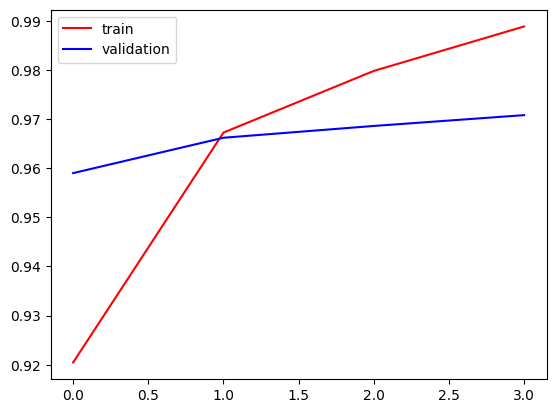

In [90]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

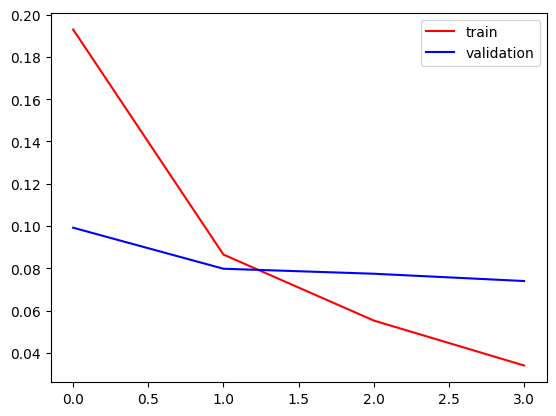

In [91]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

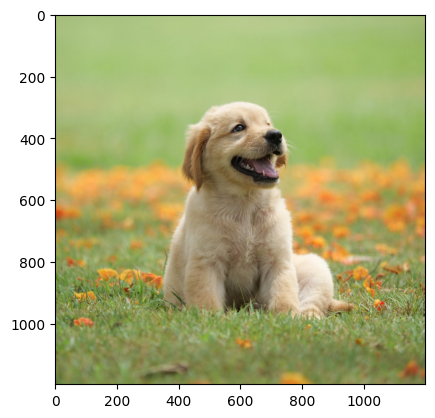

In [92]:
import cv2
test_img = cv2.imread('/content/dog_test.jpeg')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [93]:
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))
model.predict(test_input)

1/1 [==============================] - 1s 816ms/step


array([[1.]], dtype=float32)